<a href="https://colab.research.google.com/github/FGalvao77/Implementando-Redes-Generativas-Adversarias-GAN-do-ZERO-PyTorch-Deep-Learning/blob/main/C%C3%B3pia_de_01_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Implementando Redes Generativas Adversárias (GAN) do ZERO | PyTorch | Deep Learning**

---



In [1]:
# função para acessar o google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# importando as bibliotecas e as funções necessárias
import torch
import matplotlib.pyplot as plt
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn,  optim
from IPython import display

In [3]:
# definindo as configurações para uso das imagens
imgsize = 28        # resolução da imagem
batch_size = 128    # quantidade do agupamentos das imagens

In [4]:
# criando diretórios no google drive para salvar o conjunto de dados das imagens
DATA_DIR = '/content/drive/MyDrive/PrimeiraGAN'     # pasta para salvar o conjunto de dados das imagens
IMG_DIR = os.path.join(DATA_DIR, 'results')         # pasta para salvar as imagens geradas pelo modelo

In [5]:
# instanciando o transformador das imagens
fashion_transform = transforms.Compose(
    [transforms.ToTensor(), # convertendo para tensor
     transforms.Normalize(
         (0.5), (0.5))  # normalizando as imagens - com média de 0.5 e desvio padrão de 0.5
    ]
)

# instanciando o conjunto de dados na variável "fashion_data"
# passando como argumentos o diretório (DATA_DIR) onde foi realizado o download das imagens,
# o transformador (recebe fashion_transform) e download (recebe True)
fashion_data = datasets.FashionMNIST(DATA_DIR, 
                                     transform=fashion_transform,
                                     download=True)

# instanciando o objeto que irá iterar as imagens
# passando como argumentos a variável "fashion_data"
# o tamanho dos agrupamentos
# e a função "shuffle=True" para embaralhar as imagens
dataloader = DataLoader(fashion_data, 
                        batch_size=batch_size, 
                        shuffle=True)

In [6]:
# instanciando a primeira imagem e seu rótulo para visualizarmos
img, label = fashion_data[0]

In [7]:
# visualizando a imagem
img

tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1

> Veja que a imagem em questão é um tensor!

In [8]:
# visualizando o rótulo da imagem
label

9

In [9]:
# visualizando a quantidade de imagens
len(fashion_data)

60000

In [10]:
# visualizando o tipo do objeto
type(fashion_data)

torchvision.datasets.mnist.FashionMNIST

In [11]:
# criando uma função para auxiliar na visualização das imagens
def lookat_dataset(dataset, pilimg=False):
    figure = plt.figure(figsize=[16, 4])    # tamanho das imagens
    rows, cols = 2, 8   # 2 linhas por 8 colunas, totalizando 16 imagens

    # realizando um laço de repetição de 1 até 17
    for i in range(1, 17):
        sample_idx = torch.randint(len(dataset),    # visualizando as imagens aleatórias
                                   size=(1,)).item()

        img, label = dataset[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.axis('off')

        if pilimg:
            plt.imshow(img)
        else:
            img = (img.squeeze() * 0.5) + 0.5

            if len(img.shape) == 2:
                plt.imshow(img, cmap='gray')    # imagens no tons de cinza
            else:
                plt.imshow(img.permute(1, 2, 0))

    plt.show();

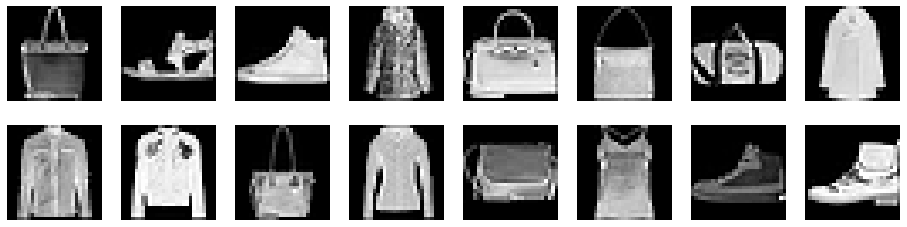

In [12]:
# visualizando as imagens
lookat_dataset(fashion_data)

In [13]:
# definindo a arquitetura da rede neural

# instanciando a classe do gerador
class Generator(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()

        # definindo as camadas da rede neural
        self.layers = nn.Sequential(

            # entrada e saída da camada
            nn.Linear(n_input, 256),
            nn.LeakyReLU(),     # função de ativação

            nn.Linear(256, 512),
            nn.LeakyReLU(),

            nn.Linear(512, 1024),
            nn.LeakyReLU(),

            nn.Linear(1024, n_output),
            nn.Tanh()
        )

    def forward(self, z):
        return self.layers(z)

# instanciando a classe do discriminador
class Discriminator(nn.Module):
    def __init__(self, n_input):
        super().__init__()
        n_output = 1

        # definindo as camadas da rede neural
        self.layers = nn.Sequential(

            # entrada e saída da camada
            nn.Linear(n_input, 1024),
            nn.LeakyReLU(0.2),      # função de ativação
       
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
        
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
     
            nn.Linear(256, n_output),
            nn.Sigmoid()
        )
            
    def forward(self, x):
        return self.layers(x)

In [14]:
# instanciando o ambiente que está rodando a rede neural
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Rodando na {device}')

Rodando na cpu


In [26]:
# instaciando a dimensão do ruído
noise_dim = 100

# instanciando o gerador com a dimensão do ruído e o tamanho das imagens
generator = Generator(noise_dim, 
                      imgsize * imgsize).to(device)
                      
discriminator = Discriminator(imgsize * imgsize).to(device)

In [27]:
# função para transformar as imagens em vetores
def images_to_vectors(images):
    return images.view(images.size(0), 
                       imgsize * imgsize)

# função para transformar os vetores para imagens  
def vectors_to_images(vectors, nc=1):
    return vectors.view(vectors.size(0), 
                        nc, imgsize, imgsize)

# função para gerar ruídos
def noise(size, dim=noise_dim, device=device):
    return torch.randn(size, 
                       dim).to(device)

# função para visualizar as imagens
def log_images(test_images, savepath=None):
    figure = plt.figure(figsize=[8, 8])
    figure.subplots_adjust(wspace=0.08,
                           hspace=0.01)
    
    rows, cols = len(test_images) // 4, 4

    for i, img in enumerate(test_images):
        figure.add_subplot(rows, cols, i + 1)
        plt.axis('off')
        plt.imshow(img.squeeze(), 
                   cmap='gray')

    if savepath is not None:   
        figure.savefig(savepath)

    plt.show();

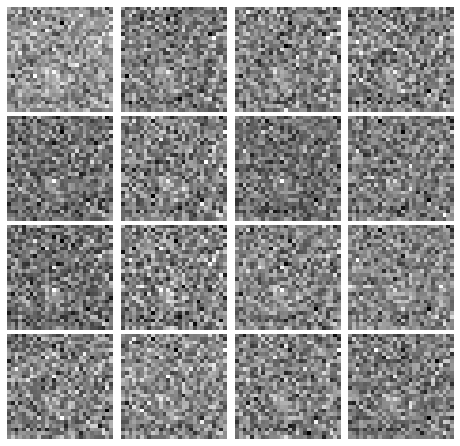

In [28]:
# tamanho das amostras
num_test_samples = 16

# definindo a semente do modelo
torch.manual_seed(7777)

# instanciando o ruído do teste
test_noise = noise(num_test_samples,
                   noise_dim)

# salvando as imagens na pasta
imagepath = os.path.join(IMG_DIR, f'{0}.jpg')

# realizando a visualização da imagem
log_images(
    vectors_to_images(
        generator(test_noise)).cpu().detach().numpy(), 
        imagepath
)

In [29]:
# função para rótulo dos dados reais
def real_data_target(size, device=device):
    return torch.ones(size, 1).to(device)

# função para rótulo dos dados falsos
def fake_data_target(size, device=device):
    return torch.zeros(size, 1).to(device)

In [30]:
# taxa de aprendizagem
lr = 0.0002

# otimizador do gerador
g_optimizer = optim.Adam(generator.parameters(), 
                         lr = lr)

# otimizador do discriminador
d_optimizer = optim.Adam(discriminator.parameters(), 
                         lr = lr)

# função para cálculo do erro
loss = nn.BCELoss()

In [31]:
# função para treinar o gerador
def train_generator(optimizer, fake_data):
    optimizer.zero_grad()

    pred = discriminator(fake_data)

    error = loss(
        pred,
        real_data_target(pred.size(0)))
    error.backward()
    
    optimizer.step()

    return error

# função para treinar o gerador
def train_discriminator(optimizer, real_data, fake_data):
    optimizer.zero_grad()

    pred_real = discriminator(real_data)
    error_real = loss(pred_real, 
                      real_data_target(real_data.size(0)))
    
    error_real.backward()

    pred_fake = discriminator(fake_data)
    error_fake = loss(pred_fake, 
                      fake_data_target(fake_data.size(0)))
    error_fake.backward()

    optimizer.step()

    return error_real + error_fake, pred_real, pred_fake

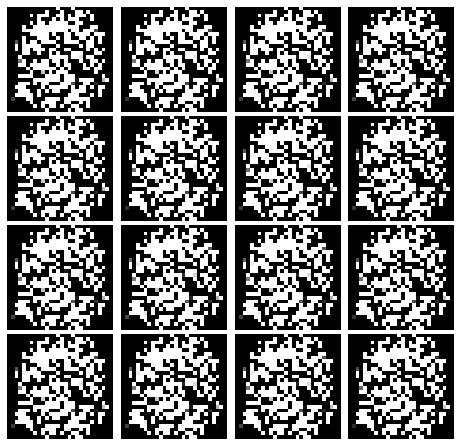

Epoch: 0 / 150 Losses: 
Discriminator: 0.0004 | Generator 8.7765
D(x): 0.9998 | D(G(z)): 0.0002


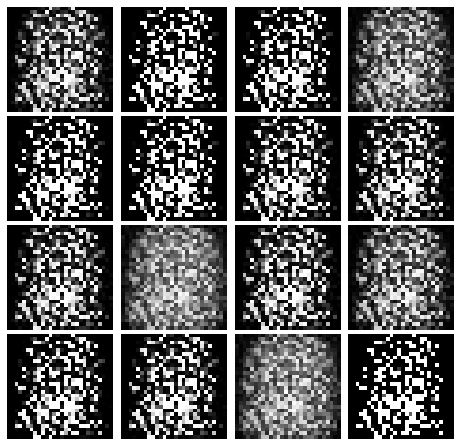

Epoch: 1 / 150 Losses: 
Discriminator: 0.0108 | Generator 11.8114
D(x): 0.9989 | D(G(z)): 0.0092


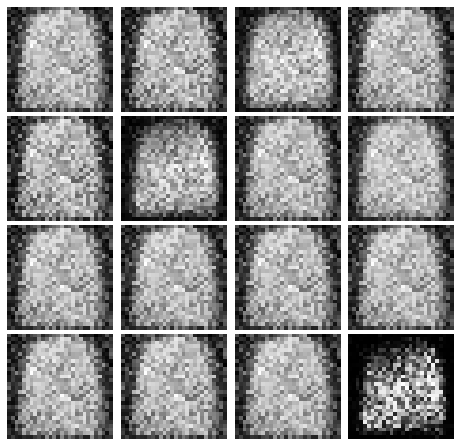

Epoch: 2 / 150 Losses: 
Discriminator: 0.2505 | Generator 9.2644
D(x): 0.9486 | D(G(z)): 0.0031


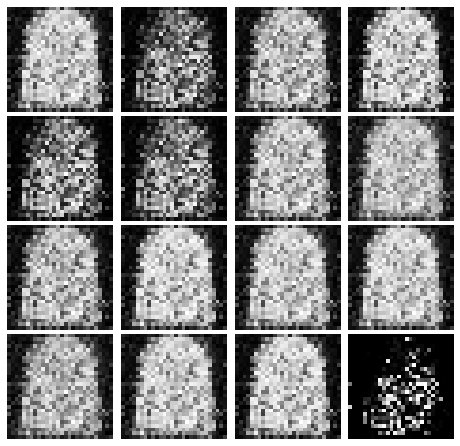

Epoch: 3 / 150 Losses: 
Discriminator: 0.0594 | Generator 13.0534
D(x): 0.9619 | D(G(z)): 0.0072


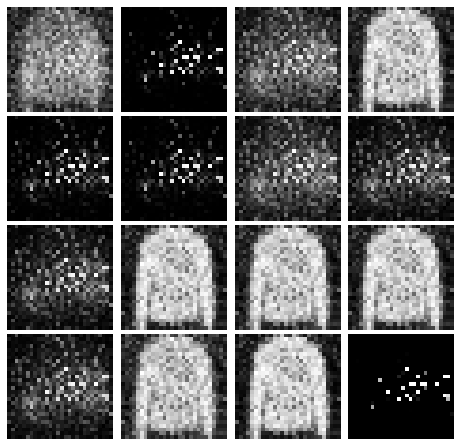

Epoch: 4 / 150 Losses: 
Discriminator: 0.0453 | Generator 6.5644
D(x): 0.9859 | D(G(z)): 0.0207


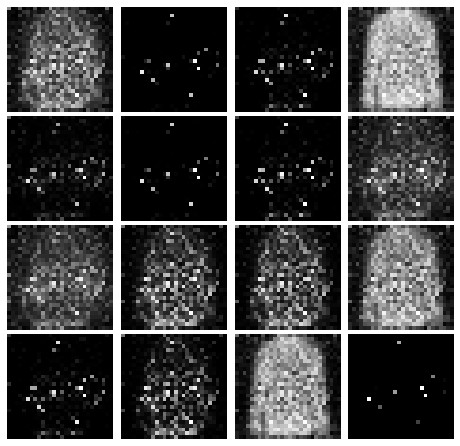

Epoch: 5 / 150 Losses: 
Discriminator: 0.2047 | Generator 5.6009
D(x): 0.9290 | D(G(z)): 0.0302


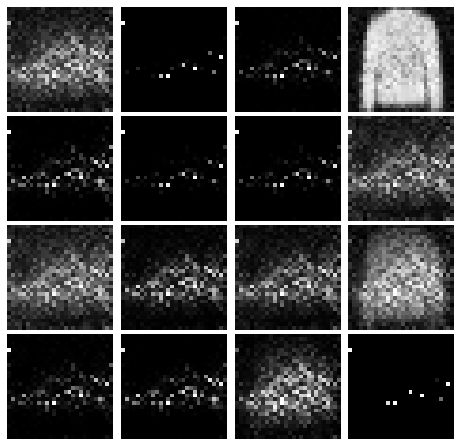

Epoch: 6 / 150 Losses: 
Discriminator: 0.1060 | Generator 8.2833
D(x): 0.9875 | D(G(z)): 0.0583


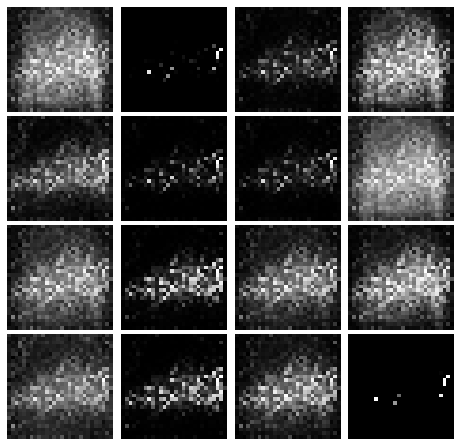

Epoch: 7 / 150 Losses: 
Discriminator: 0.0452 | Generator 7.8924
D(x): 0.9934 | D(G(z)): 0.0354


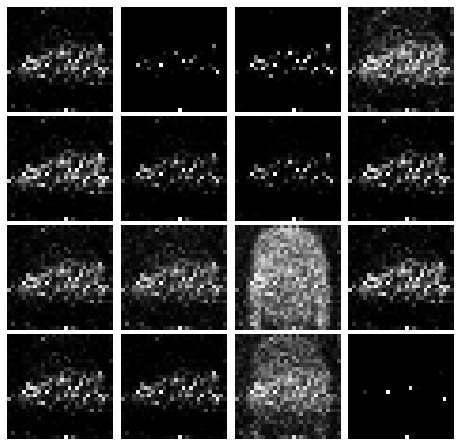

Epoch: 8 / 150 Losses: 
Discriminator: 0.1952 | Generator 3.8236
D(x): 0.9486 | D(G(z)): 0.0520


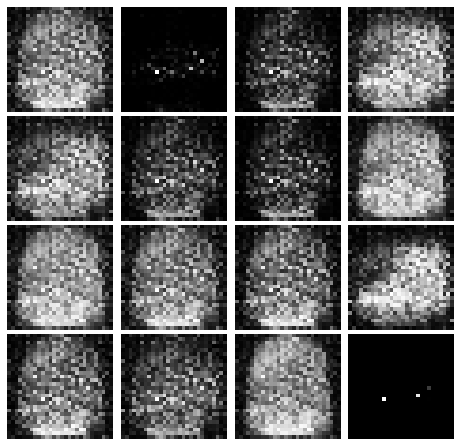

Epoch: 9 / 150 Losses: 
Discriminator: 0.0573 | Generator 4.8801
D(x): 0.9796 | D(G(z)): 0.0219


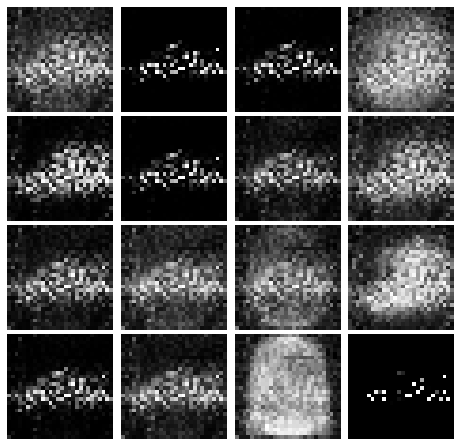

Epoch: 10 / 150 Losses: 
Discriminator: 0.3521 | Generator 3.8997
D(x): 0.9272 | D(G(z)): 0.0569


In [ ]:
# instanciando o número de épocas para o treino
num_epochs = 150

# lista para salvar os erros do gerador e do discriminador
G_losses = []
D_losses = []

for epoch in range(num_epochs):
    for realbatch, _ in dataloader:

        real_data = images_to_vectors(realbatch).to(device)

        fake_data = generator(
            noise(real_data.size(0)))

        d_error, dpred_real, dpred_fake = (
            train_discriminator(d_optimizer, 
                                real_data, 
                                fake_data))
        
        fake_data = generator(noise(realbatch.size(0)))
        
        g_error = train_generator(g_optimizer, 
                                  fake_data)
        
    imagepath = os.path.join(IMG_DIR, 
                             f'{epoch + 1}.jpg')
    
    test_images = vectors_to_images(
        generator(test_noise)).cpu().detach().numpy()

    log_images(test_images, imagepath)

    G_losses.append(g_error)
    D_losses.append(d_error)

    print(f'Epoch: {epoch} / {num_epochs} Losses: ')
    print(f'Discriminator: {d_error:.4f} | Generator {g_error:.4f}')
    print(f'D(x): {dpred_real.mean():.4f} | D(G(z)): {dpred_fake.mean():.4f}')

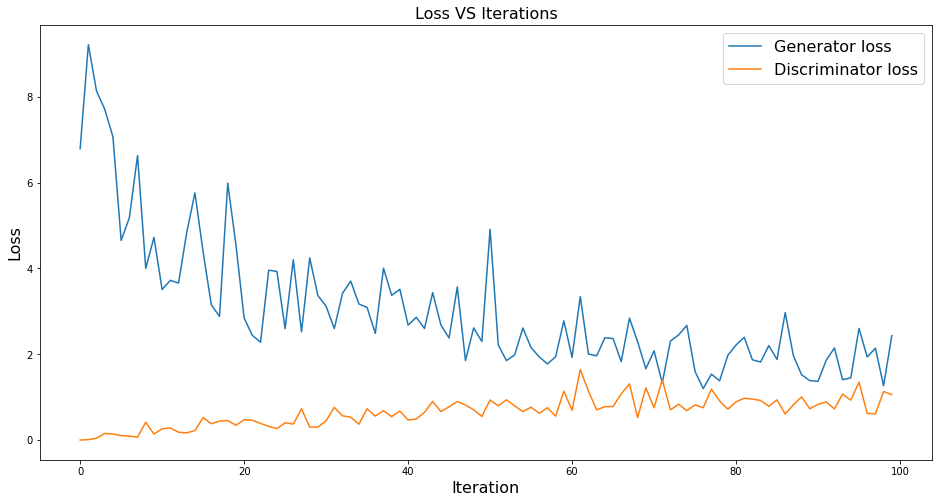

In [ ]:
# função para visualizar os erros do gerador e do discriminador
def plot_losses(losses):
    fig = plt.figure(figsize=[16, 8])
    ax = fig.gca()

    for loss_name, loss_values in losses.items():
        loss_values = [k.item() for k in loss_values]
        ax.plot(loss_values, label=loss_name)

    ax.legend(fontsize='16')
    ax.set_xlabel('Iteration', fontsize='16')
    ax.set_ylabel('Loss', fontsize='16')
    ax.set_title('Loss VS Iterations', fontsize='16')

plot_losses({
    'Generator loss': G_losses, 
    'Discriminator loss': D_losses
});

In [ ]:
# importando a biblioteca para gerar gif
import imageio

In [ ]:
# lista para salvar o gif
images = []

# realizando um laço de repetição 
for filename in sorted(os.listdir(IMG_DIR), key = lambda x: float(x.split('.')[0])):
    if filename.endswith('.jpg'):
        filepath = os.path.join(IMG_DIR, filename)
        images.append(imageio.imread(filepath))

imageio.mimsave('fashion_training.gif', images)